# Query-by-Example (QbE) Search Using DTW

## Preliminary

In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [9]:
from __future__ import division
from __future__ import print_function
from os import path
from python_speech_features import delta
from python_speech_features import mfcc
import glob
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav
import sys
import simpleaudio as sa
from pydub import AudioSegment
from pydub.playback import play
from shennong.audio import Audio
from shennong.features.processor.mfcc import MfccProcessor
from shennong.features.postprocessor.delta import DeltaPostProcessor
from shennong.features.postprocessor.cmvn import CmvnPostProcessor
from progress.bar import Bar
from datetime import datetime
from nltk import word_tokenize
import nltk
#nltk.download('punkt')
import Levenshtein as lev
import pickle

sys.path.append("..")
sys.path.append(path.join("..", "utils"))

from speech_dtw import qbe

/home/josh/miniconda3/lib/python3.7/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
/home/josh/miniconda3/lib/python3.7/site-packages/pydub/utils.py:184: RuntimeWarning: Couldn't find ffplay or avplay - defaulting to ffplay, but may not work
  warn("Couldn't find ffplay or avplay - defaulting to ffplay, but may not work", RuntimeWarning)


## Extract MFCC Features

In [10]:
def get_mfcc_dd(wav_fn):
    """Return the MFCCs with deltas and delta-deltas for a audio file."""
    audio = Audio.load(wav_fn)
    processor = MfccProcessor(sample_rate=audio.sample_rate, window_type="hamming",frame_length=0.025, frame_shift=0.01,
                              cepstral_lifter=26.0,low_freq=0, vtln_low=60, vtln_high=7200, high_freq=audio.sample_rate/2)
    d_processor = DeltaPostProcessor(order=2)
    mfcc_static = processor.process(audio.channel(0), vtln_warp=1.0)
    mfcc_deltas = d_processor.process(mfcc_static)
    #print(mfcc_static.shape, mfcc_deltas.shape)
    features = mfcc_deltas._to_dict()["data"]
    features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
    #print(features.shape)
    return features

## Set Directories

In [14]:
# Titles of the saved data file and plot diagram
ftitle = '30 topic words with respearking'
plot_title = '30 topic words with respearking'
# Set the directory for word examples that includes the wav and corresponding txt files
words_dir = 'kunwok_words/interview_words_josh'
word_wav = '*.wav'
# Set the directory for target speech 
target_speech_dir = 'kunwok_speech/interview_rspk'
target_speech_txt = '*.txt'
target_speech_wav = '*.wav'

## Take Query Words

In [15]:
word_list = []
for wav_fn in sorted(glob.glob(path.join(words_dir, word_wav))):
    query = {} 
    txt_file = open(wav_fn.replace('wav','txt'), "r")
    query["word"] = txt_file.read()
    rate, signal = wav.read(wav_fn)
    length = len(signal) / rate * 1000
    query_mfcc = get_mfcc_dd(wav_fn)   
    query["length"] = length
    query["data"] = query_mfcc
    query["audio"] = AudioSegment.from_file(wav_fn, format="wav")
    query["thres"] = 1
    word_list.append(query)

## Take Target Speech Utterances

In [16]:
speech_utt= []
speech_utt= []
for wav_fn in sorted(glob.glob(path.join(target_speech_dir, target_speech_wav))):
    dic = {}
    #print(wav_fn)
    dic["audio"] = AudioSegment.from_file(wav_fn, format="wav")
    dic["data"] = get_mfcc_dd(wav_fn)
    txt_file = open(wav_fn.replace('wav','txt'), "r")
    dic["word"] = txt_file.read()
    speech_utt.append(dic)

In [25]:
# Test word sample
print(speech_utt[5]['word'])  
play(speech_utt[5]['audio'])

ngandi-nan ngadberre kun-warre kabirri-nan


In [ ]:
# Test DTW sweep & plot
print(word_list[11]["word"])
print(speech_utt[2]["word"])
sweep_original = qbe.dtw_sweep(np.float64(word_list[11]["data"]), np.float64(speech_utt[2]["data"]))
plt.plot(sweep_original,color='green')

## Calculate the Min DTW distance of Each Word and Utterance Pair

In [17]:
from tqdm import tqdm
from statistics import mean
result = []
num_uttword = 0
num_match = 0 
num_prediction = 0
num_nomatch = 0
thres_distance = 1
correct_dtw_score = []
incorrect_dtw_score = []
i = 1

def sortThird(val): 
    return val[2]  

for uttr in range(0,len(speech_utt)):
    dic = {}
    dic['correct_words'] = []
    dic['incorrect_words'] = []
    dic['correct_dtw'] = []
    dic['incorrect_dtw'] = []
    prediction = []
    match = set()
    close_words = set()
    length = len(speech_utt[uttr]["data"])/100

    for query in word_list:        
        query_word = query["word"].lower()
        query_mfcc = np.float64(query["data"])
        search_mfcc = np.float64(speech_utt[uttr]["data"])
        dtw_costs = qbe.dtw_sweep(query_mfcc, search_mfcc)
        min_dtw = np.min(dtw_costs)
        utt_sent = word_tokenize(speech_utt[uttr]['word'].lower().replace('-',''))
        time = dtw_costs.index(min_dtw)*3/100
        hasMatch = False
        dic['sentence'] = utt_sent
        
        if min_dtw < 0.33:
            prediction.append((query_word, time, min_dtw))
      
        for utt_word in utt_sent:
            if lev.distance(query_word,utt_word)<=thres_distance:
                dic['correct_words'].append(utt_word)
                dic['correct_dtw'].append(min_dtw)
                correct_dtw_score.append(min_dtw)
                hasMatch = True
                break
                
        if hasMatch == False:
            dic['incorrect_words'].append(query_word)
            dic['incorrect_dtw'].append(min_dtw)
            incorrect_dtw_score.append(min_dtw)
        
    num_uttword += len(utt_sent)
    num_prediction += len(match)
    num_match += len(dic['correct_words'])
    num_nomatch += len(dic['incorrect_words'])
    
    prediction.sort(key = sortThird)
    cutoff = False
    i+=1
    result.append(dic)

print('\nCorrect DTW Average:', end=' ')
print(mean(correct_dtw_score))
print('Incorrect DTW Average:', end=' ')
print(mean(incorrect_dtw_score))
print('Number of Matching Words:', end=' ')
print(num_match)
print('Done\n') 


Correct DTW Average: 0.3471752359292771
Incorrect DTW Average: 0.387756742560083
Number of Matching Words: 104
Done



## Plot the Distribution of Correct Match Pairs and Incorrect Match Pairs

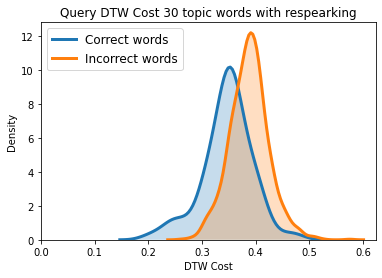

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(correct_dtw_score, shade=True, linewidth = 3, label = 'Correct words')
sns.kdeplot(incorrect_dtw_score, shade=True, linewidth = 3, label = 'Incorrect words')
    
# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Query DTW Cost ' + plot_title)
plt.xlabel('DTW Cost')
plt.xlim(xmin=0)
plt.ylabel('Density')
plt.savefig(ftitle+'_dtw.png', dpi=400)

## Get Precisions and Recalls

In [19]:
# This function returns the precision and recall given the DTW threshold
def get_score(dtw_threshold, match_dtw_score, nomatch_dtw_score, word_count):
    num_spotted = len(list(filter(lambda x: x < dtw_threshold, match_dtw_score)))
    num_uttword = word_count
    num_incorrect = len(list(filter(lambda x: x < dtw_threshold, nomatch_dtw_score)))
    num_match = num_incorrect + num_spotted
    num_unspotted = len(match_dtw_score) - num_spotted
    precision = num_spotted/num_match
    recall = num_spotted/(num_spotted+num_unspotted)
    return precision, recall

206
DTW: 0.3491752359292681
Precision: 0.2175732217573222
Recall: 0.5
Max F1: 0.3032069970845481


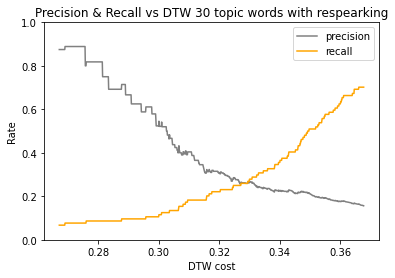

In [20]:
from matplotlib.pyplot import plot, title, xlabel, ylabel, savefig, legend, ylim
from numpy import array, arange

dtw_performance = []
dtw_threshold = []
max_f1 = 0
word_count = 0
hasFoundRecall = False
lower_bound = 0.08
higher_bound = 0.02
granularity = 0.0001

for uttr in result:
    word_count += len(uttr['sentence'])

for i in arange(mean(correct_dtw_score)-lower_bound,mean(incorrect_dtw_score)-higher_bound,granularity):
    p, r = get_score(i, correct_dtw_score, incorrect_dtw_score, word_count)
    f1 = 2*((p*r)/(p+r))
    if f1>max_f1:
        max_f1=f1
        default_dtw = i
        best_p = p
        best_r = r
    dtw_performance.append((p,r))
    dtw_threshold.append(i)
    
print('DTW: '+str(default_dtw)+'\nPrecision: '+str(best_p)+'\nRecall: '+str(best_r))
print('Max F1: '+str(max_f1))

# Formatting the plot
dtw_threshold = array(dtw_threshold) 
precision, recall = zip(*dtw_performance)
colors_and_labels = (
    (precision, 'grey', 'precision'),
    (recall, 'orange', 'recall')
)

for performance, color, label in colors_and_labels:
    plot(dtw_threshold, array(performance), color=color, label=label)
title('Precision & Recall vs DTW '+plot_title)
xlabel('DTW cost')
ylabel('Rate')
ylim(0,1)
legend()

savefig(ftitle+'_accuracy.png', dpi=400)

## Print Out Word-Spotting Examples 

In [24]:
ex = [2,17,44]
for uttr_id in ex:
    spotted_words = []
    false_words = []
    fail_to_spot = []
    match = set()
    close_words = set()
    for query in word_list:        
        query_word = query["word"].lower()
        query_mfcc = np.float64(query["data"])
        search_mfcc = np.float64(speech_utt[uttr_id]["data"])
        dtw_costs = qbe.dtw_sweep(query_mfcc, search_mfcc)
        min_dtw = np.min(dtw_costs)
        utt_sent = word_tokenize(speech_utt[uttr_id]['word'].lower().replace('-',''))
        hasMatch = False               

        for utt_word in utt_sent:
            if min_dtw < default_dtw:
                if lev.distance(query_word,utt_word)<=thres_distance:
                    spotted_words.append(utt_word)
                    hasMatch = True
                    break
            else:
                if lev.distance(query_word,utt_word)<=thres_distance:
                    fail_to_spot.append(utt_word)
                
        if hasMatch == False and min_dtw < default_dtw:
            false_words.append(query_word) 

    print('Utterance: \t'+speech_utt[uttr_id]['word'])
    print('Spotted Words:', end='\t')
    for word in spotted_words:
        print(word, end=' ') 
    print('\nFalse Positive:', end='\t')
    for word in false_words:
        print(word, end=' ')
    print('\nFailed to Spot:', end='\t')
    for word in fail_to_spot:
        print(word, end=' ')
    print('\n') 


Utterance: 	kun-warre kumekke wurdwurd kabirri-nan
Spotted Words:	kabirrinan 
False Positive:	bedman bedmanwali bolkki kabirribolbme karrme kayime kunred manekke 
Failed to Spot:	wurdwurd 

Utterance: 	wurdwurd ngadberre yiman kayime
Spotted Words:	kayime ngadberre yiman 
False Positive:	bedman bedmanwali bolkki kabirribolbme kabirrinan karrme kunred manekke ngarrbenbukkan yerre 
Failed to Spot:	wurdwurd 

Utterance: 	kun-warre kumekke kabirri-nan
Spotted Words:	
False Positive:	manekke njaleken wanjh yerre 
Failed to Spot:	kabirrinan 



## Save Data

In [ ]:
data = {}
data['result'] = result
data['match_dtw'] = correct_dtw_score
data['nomatch_dtw'] = incorrect_dtw_score
data['precision']= best_p
data['recall'] = best_r
data['dtw']= default_dtw
data['maxf1']= max_f1

In [ ]:
with open(ftitle+'.data', 'wb') as filehandle:
    pickle.dump(data, filehandle)